In [20]:
from warnings import filterwarnings

filterwarnings("ignore")

import numpy as np
import numpy.typing as npt
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from PyEMD import EMD, CEEMDAN, EEMD
from sklearn.feature_selection import mutual_info_regression

from quant_invest_lab.data_provider import download_crypto_historical_data
from quant_invest_lab.backtest import (
    ohlc_long_only_backtester,
    ohlc_short_only_backtester,
)
from quant_invest_lab.simulation import generate_brownian_candle_from_dataframe
from modules.filters import emd_detrending, emd_smoothing

In [50]:
SYMBOL = "ALGO-USDT"
TIMEFRAME = "12hour"

df = download_crypto_historical_data(SYMBOL, TIMEFRAME).iloc[-3000:]
df.dropna(inplace=True)
print(df.shape)
df.head()

(2862, 8)


Timestamp    Open   Close    High     Low  \
Date                                                              
2019-06-21 02:00:00  1561075200  1.0000  3.1764  5.0000  1.0000   
2019-06-21 14:00:00  1561118400  3.1780  3.1696  3.2420  2.8631   
2019-06-22 02:00:00  1561161600  3.1819  2.4936  3.1846  2.3705   
2019-06-22 14:00:00  1561204800  2.4820  2.1515  2.4820  1.8322   
2019-06-23 02:00:00  1561248000  2.1516  1.9994  2.1931  1.9501   

                            Amount        Volume   Returns  
Date                                                        
2019-06-21 02:00:00  309857.890866  9.135933e+05  0.000000  
2019-06-21 14:00:00  549973.966151  1.685115e+06 -0.002141  
2019-06-22 02:00:00  547414.076606  1.397316e+06 -0.213276  
2019-06-22 14:00:00  480697.575475  1.028847e+06 -0.137191  
2019-06-23 02:00:00  450103.149297  9.051475e+05 -0.070695

## Offline


In [51]:
df["Close_denoised"] = emd_smoothing(df.Close, 3)

df["Close_denoised_signal"] = df["Close_denoised"].diff().fillna(1.0).apply(np.sign)

In [52]:
def buy_func(row: pd.Series, prev_row: pd.Series) -> bool:
    return True if row.Close_denoised_signal == 1 else False


def sell_func(row: pd.Series, prev_row: pd.Series, trading_days: pd.Series) -> bool:
    return True if row.Close_denoised_signal == -1 else False


# Backtest your strategy
ohlc_long_only_backtester(
    df=df,
    long_entry_function=buy_func,
    long_exit_function=sell_func,
    timeframe=TIMEFRAME,
    initial_equity=1000,
)

-------------  Initial informations  -------------
Period: [2019-06-21 02:00:00] -> [2023-05-21 14:00:00]
Intial balance: 1000.00 $
Taker fees: 0.10 %, Maker fees: 0.10 %, All the metrics will be calculated considering these fees

------------  Strategy performances  -------------
Strategy final net balance: 22741544.88 $, return: 2274054.49 %
Buy & Hold final net balance: 50.84 $, returns: -94.92 %
Strategy winrate ratio: 85.94 %
Strategy profit factor ratio: 4.54
Strategy expectancy: 376.18 %

-------  Returns statistical information  --------
Expected return : 0.77 %, annuzalized: 563.98 %
Median return : 0.43 %, annuzalized: 311.76 %
Expected volatility: 4.56 %, annualized: 123.34 %
Skewness: 1.32 vs 0.15 (buy and hold), <0 = left tail, >0 = right tail -> the higher the better
Kurtosis: 8.57 vs 7.37 (buy and hold) , >3 = fat tails, <3 = thin tails -> the lower the better
12hour-95%-VaR: -5.85 % vs -7.28 % (buy and hold) -> the lower the better
12hour-95%-CVaR: -8.49 % vs -11.03 % (

## Offline with generated dataframe

In [53]:

df = generate_brownian_candle_from_dataframe(
    download_crypto_historical_data(SYMBOL, TIMEFRAME), TIMEFRAME, 1000
)
df['Returns'] = df['Close'].pct_change().fillna(0)
df.dropna(inplace=True)
df["Close_denoised"] = emd_smoothing(df.Close, 3)

df["Close_denoised_signal"] = df["Close_denoised"].diff().fillna(1.0).apply(np.sign)

def buy_func(row: pd.Series, prev_row: pd.Series) -> bool:
    return True if row.Close_denoised_signal == 1 else False


def sell_func(row: pd.Series, prev_row: pd.Series, trading_days: pd.Series) -> bool:
    return True if row.Close_denoised_signal == -1 else False


# Backtest your strategy
ohlc_long_only_backtester(
    df=df,
    long_entry_function=buy_func,
    long_exit_function=sell_func,
    timeframe=TIMEFRAME,
    initial_equity=1000,
)

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


-------------  Initial informations  -------------
Period: [2022-01-06 12:00:00] -> [2023-05-21 00:00:00]
Intial balance: 1000.00 $
Taker fees: 0.10 %, Maker fees: 0.10 %, All the metrics will be calculated considering these fees

------------  Strategy performances  -------------
Strategy final net balance: 20158.55 $, return: 1915.85 %
Buy & Hold final net balance: 402.34 $, returns: -59.77 %
Strategy winrate ratio: 92.31 %
Strategy profit factor ratio: 3.65
Strategy expectancy: 329.28 %

-------  Returns statistical information  --------
Expected return : 0.65 %, annuzalized: 475.01 %
Median return : 0.42 %, annuzalized: 309.81 %
Expected volatility: 4.65 %, annualized: 125.53 %
Skewness: 0.07 vs 0.17 (buy and hold), <0 = left tail, >0 = right tail -> the higher the better
Kurtosis: -0.26 vs -0.21 (buy and hold) , >3 = fat tails, <3 = thin tails -> the lower the better
12hour-95%-VaR: -7.02 % vs -7.20 % (buy and hold) -> the lower the better
12hour-95%-CVaR: -8.67 % vs -8.67 % (buy 

## Online


In [54]:
df = download_crypto_historical_data(SYMBOL, TIMEFRAME).iloc[-3300:]


def online_denoise(
    closes: pd.Series,
    with_memory: bool = False,
    series_name: str = "Close",
):
    if not with_memory:
        return np.sign(np.diff(emd_smoothing(closes, 3))[-1])

    full_closes = df.loc[: closes.index[-1]][series_name]
    return np.sign(np.diff(emd_smoothing(full_closes, 3))[-1])


df["Close_denoised_signal"] = df.Close.rolling(300).apply(
    online_denoise, args=(False, "Close")
)

df.dropna(inplace=True)
df.head()

Timestamp    Open   Close    High     Low        Amount  \
Date                                                                            
2019-11-17 13:00:00  1573992000  0.2690  0.2672  0.2723  0.2672  15574.526525   
2019-11-18 01:00:00  1574035200  0.2672  0.2496  0.2678  0.2496  29257.741200   
2019-11-18 13:00:00  1574078400  0.2507  0.2489  0.2559  0.2443  51544.673400   
2019-11-19 01:00:00  1574121600  0.2489  0.2335  0.2515  0.2335  55989.591515   
2019-11-19 13:00:00  1574164800  0.2337  0.2437  0.2443  0.2337  33180.383925   

                           Volume   Returns  High_from_body  Low_from_body  \
Date                                                                         
2019-11-17 13:00:00   4205.179600 -0.007798        1.012268       0.000000   
2019-11-18 01:00:00   7579.726072 -0.065868        1.002246       0.000000   
2019-11-18 13:00:00  12824.406270 -0.002804        1.020742       0.018481   
2019-11-19 01:00:00  13683.705615 -0.061872        1.010446       0.000000   
2019-11-19 13:00:00   7915.390412  0.043683        1.002462       0.000000   

                     Open_by_close  Close_denoised_signal  
Date                                                       
2019-11-17 13:00:00       1.006737                   -1.0  
2019-11-18 01:00:00       1.070513                   -1.0  
2019-11-18 13:00:00       1.007232                   -1.0  
2019-11-19 01:00:00       1.065953                   -1.0  
2019-11-19 13:00:00       0.958966                   -1.0

In [55]:
def buy_func(row: pd.Series, prev_row: pd.Series) -> bool:
    return True if row.Close_denoised_signal == 1 else False


def sell_func(row: pd.Series, prev_row: pd.Series, trading_days: pd.Series) -> bool:
    return True if row.Close_denoised_signal == -1 else False


# Backtest your strategy
ohlc_long_only_backtester(
    df=df,
    long_entry_function=buy_func,
    long_exit_function=sell_func,
    timeframe=TIMEFRAME,
    initial_equity=1000,
)

-------------  Initial informations  -------------
Period: [2019-11-17 13:00:00] -> [2023-05-21 14:00:00]
Intial balance: 1000.00 $
Taker fees: 0.10 %, Maker fees: 0.10 %, All the metrics will be calculated considering these fees

------------  Strategy performances  -------------
Strategy final net balance: 1196.46 $, return: 19.65 %
Buy & Hold final net balance: 599.70 $, returns: -40.03 %
Strategy winrate ratio: 50.46 %
Strategy profit factor ratio: 1.19
Strategy expectancy: 10.30 %

-------  Returns statistical information  --------
Expected return : 0.12 %, annuzalized: 84.82 %
Median return : 0.13 %, annuzalized: 95.09 %
Expected volatility: 4.62 %, annualized: 124.93 %
Skewness: 0.19 vs 0.12 (buy and hold), <0 = left tail, >0 = right tail -> the higher the better
Kurtosis: 7.80 vs 6.42 (buy and hold) , >3 = fat tails, <3 = thin tails -> the lower the better
12hour-95%-VaR: -7.38 % vs -7.17 % (buy and hold) -> the lower the better
12hour-95%-CVaR: -10.88 % vs -10.61 % (buy and ho

# Signal decomposition


In [7]:
def emd(signal):
    emd = EMD(DTYPE=np.float16, spline_kind="cubic")  # CEEMDAN()
    imfs = emd(signal.values)

    t = [i for i in range(len(signal))]
    N = imfs.shape[0]
    fig, axs = plt.subplots(N + 1, 1, figsize=(25, 11))
    axs[0].plot(t, signal)
    axs[0].set_title("Original Signal")
    for n, imf in enumerate(imfs):
        axs[n + 1].plot(t, imf)
        axs[n + 1].set_title(f"IMF {n}")

    return imfs

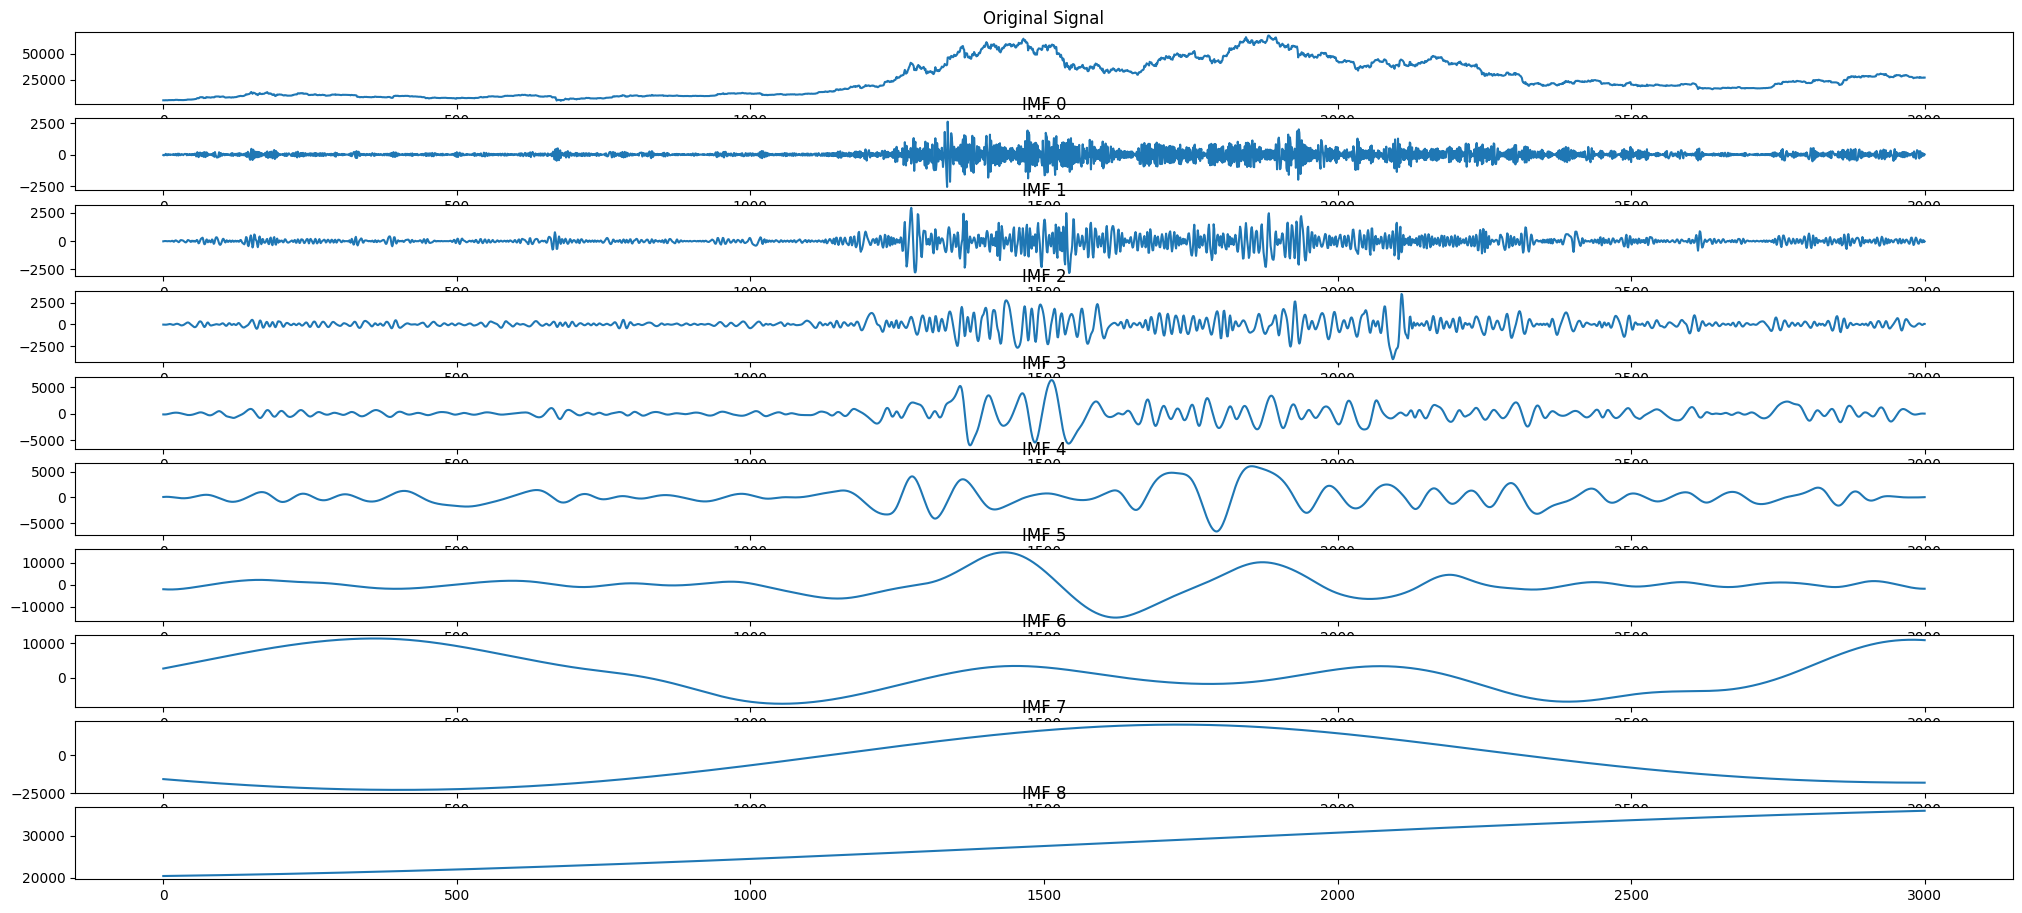

In [8]:
imfs = emd(df["Close"])

In [9]:
def phase_spectrum(imfs):
    imfs_p = []
    fig, axs = plt.subplots(len(imfs), 1, figsize=(25, 11))
    for i, imf in enumerate(imfs):
        trans = np.fft.fft(imf)
        imf_p = np.arctan(trans.imag / trans.real)

        imfs_p.append(imf_p)

        axs[i].plot(imf_p, "o")
        axs[i].set_title(f"IMF {i}")

    return imfs_p

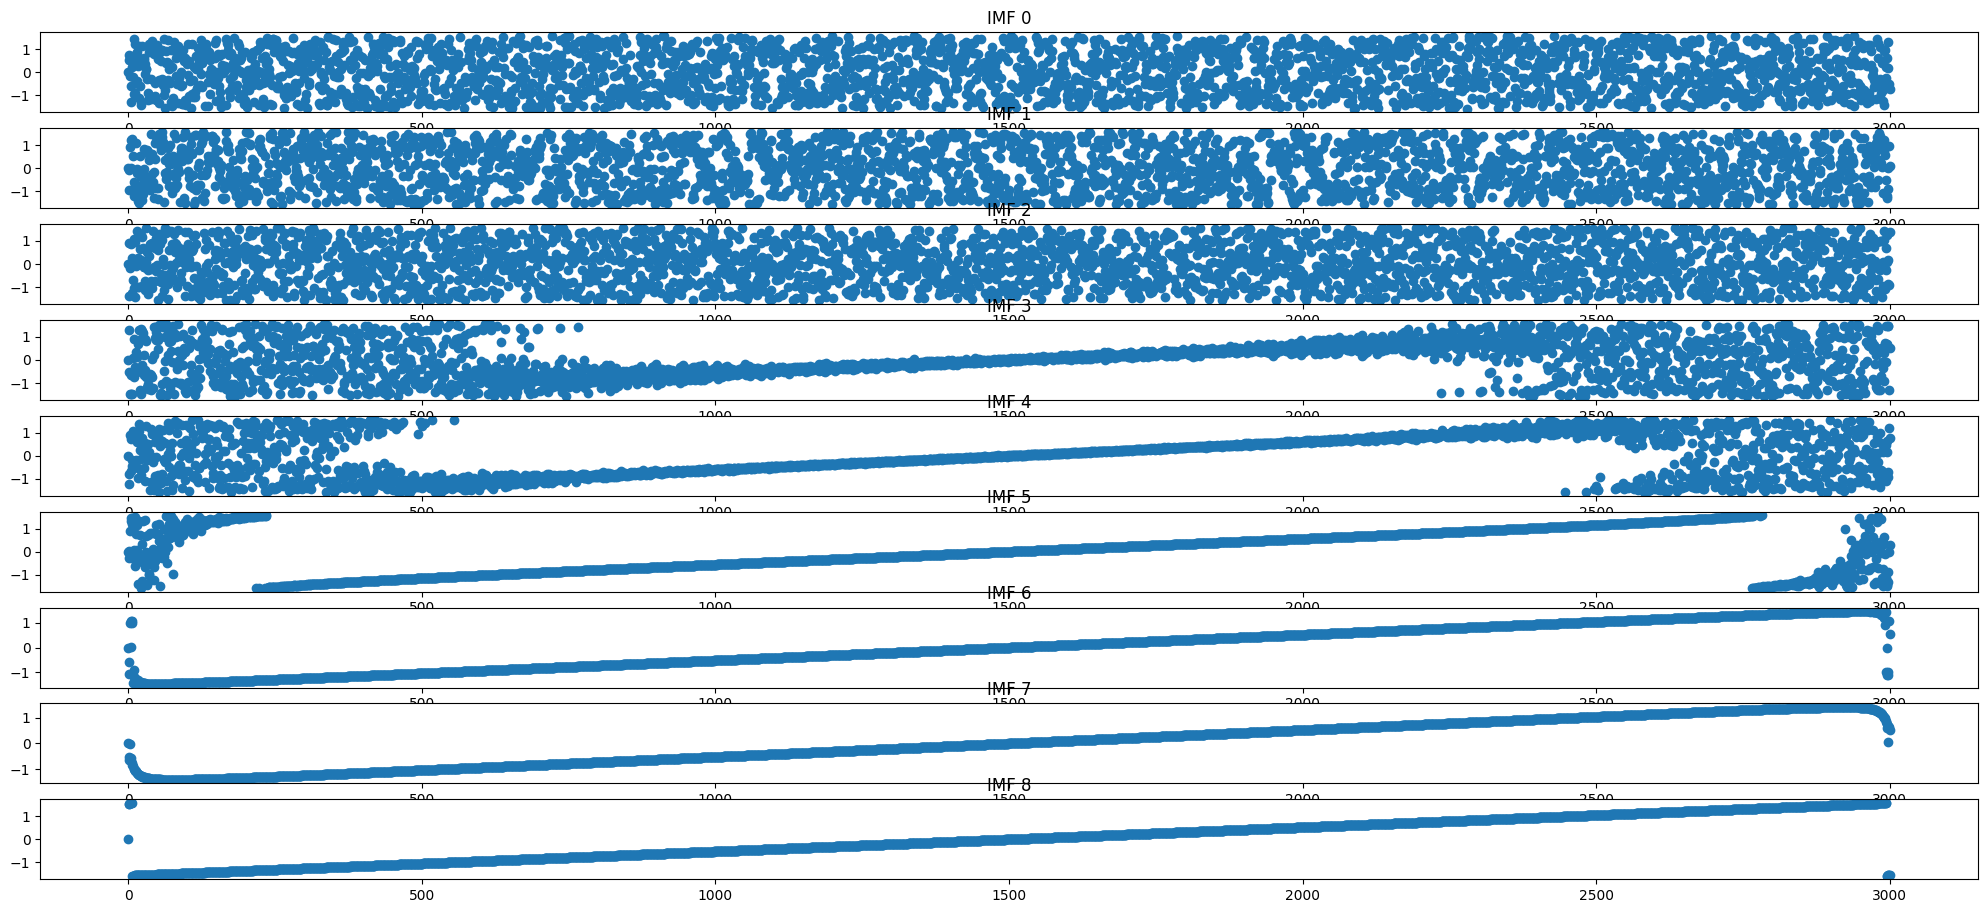

In [10]:
imfs_p = phase_spectrum(imfs)

In [11]:
def phase_mi(phases):
    mis = []
    for i in range(len(phases) - 1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i + 1])[0])

    return np.array(mis)


mis = phase_mi(imfs_p)


def divide_signal(signal, imfs, mis, cutoff=0.75):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:cut_point], axis=0)
    deterministic_component = np.sum(imfs[cut_point:], axis=0)

    t = [i for i in range(len(signal))]

    fig, axs = plt.subplots(3, 1, figsize=(25, 11))
    axs[0].plot(t, signal.values)
    axs[0].set_title("Original Signal")

    axs[1].plot(t, stochastic_component)
    axs[1].set_title("Stochastic Component")

    axs[2].plot(t, deterministic_component)
    axs[2].set_title("Deterministic Component")

    return stochastic_component, deterministic_component

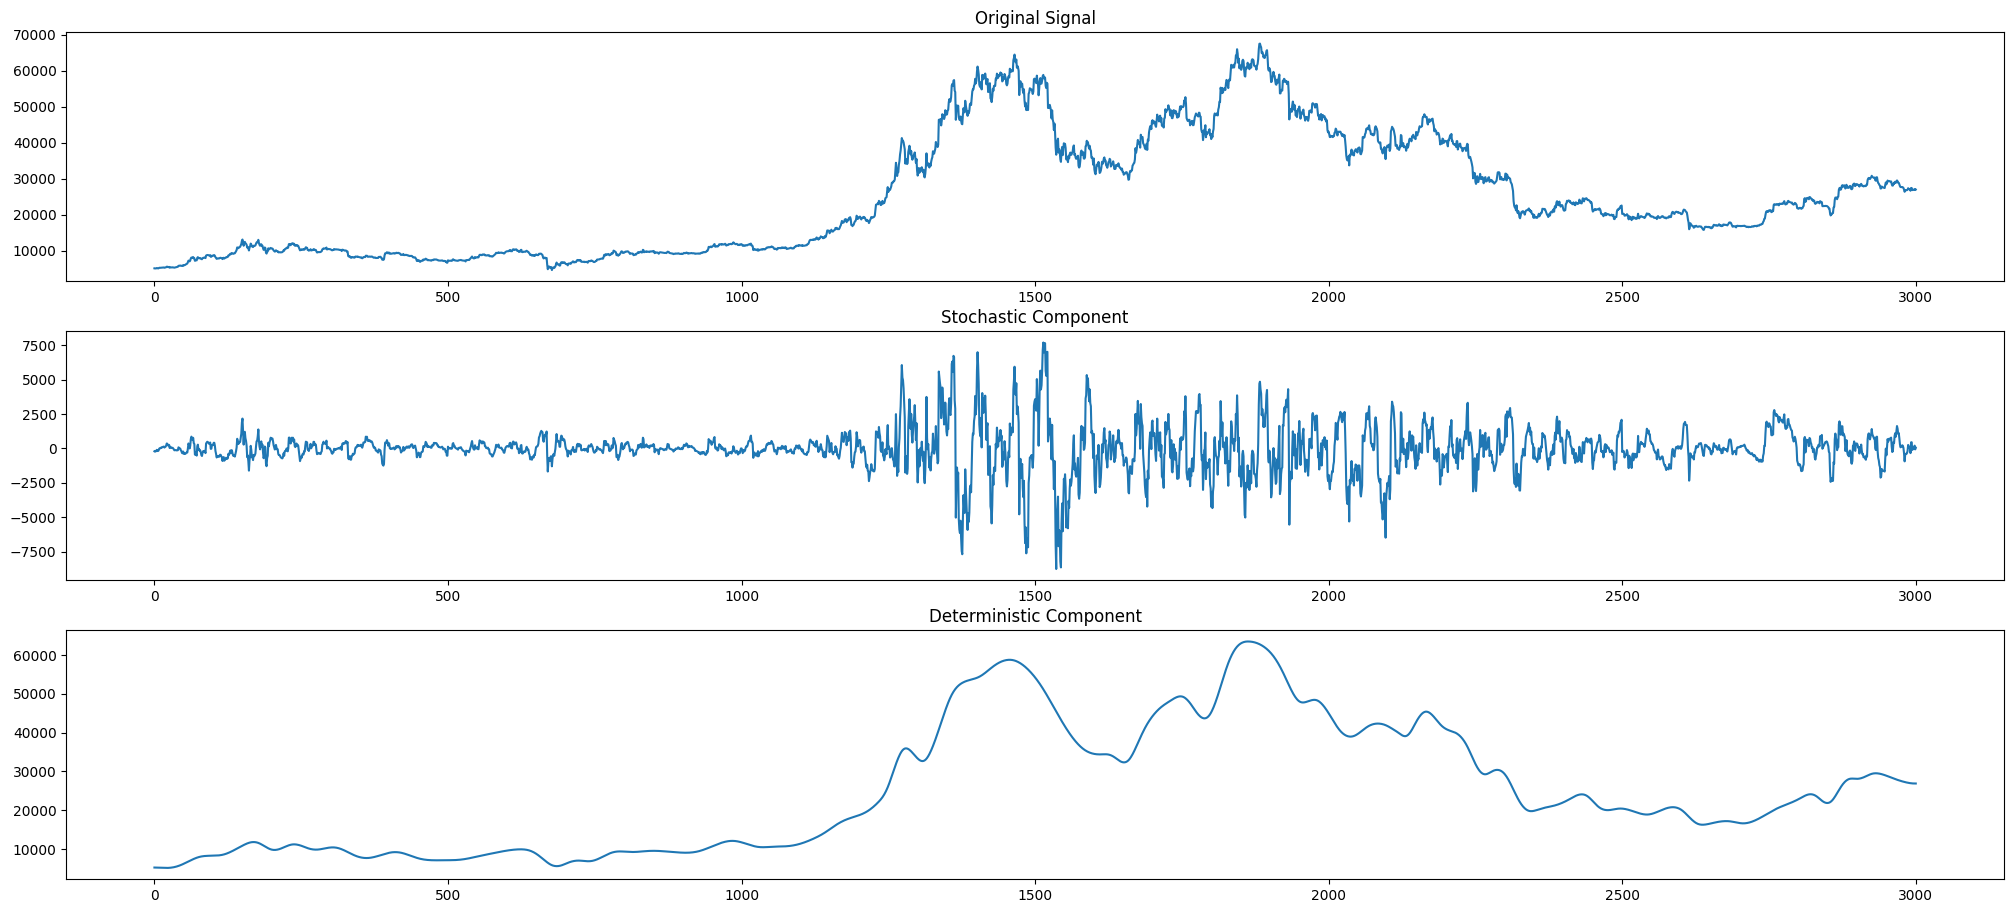

In [12]:
stochastic_component, deterministic_component = divide_signal(
    df["Close"], imfs, mis, cutoff=0.96
)

In [13]:
df["deterministic_component"] = deterministic_component
df["stochastic_component"] = stochastic_component
df["deterministic_component_diff"] = df["deterministic_component"].diff()
df.dropna(inplace=True)

fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Deterministic data",
        x=df.index,
        y=df["deterministic_component"],
    ),
    row=1,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Fourrier extrapolation (prediction)",
)

# Signal generation


In [14]:
df["deterministic_component_diff"] = df.deterministic_component.diff(1)
df.dropna(inplace=True)

In [15]:
def derivative_transition(set_of_rows) -> str:
    return (
        1
        if set_of_rows[0] < 0 and set_of_rows[-1] > 0
        else -1
        if set_of_rows[0] > 0 and set_of_rows[-1] < 0
        else 0
    )


df["Signal"] = (
    df["deterministic_component_diff"].rolling(2).apply(derivative_transition)
)

df.dropna(inplace=True)
df.head()

Timestamp    Open   Close    High     Low      Amount  \
Date                                                                            
2019-04-14 02:00:00  1.555200e+09  5045.8  5044.0  5066.7  5002.5   80.969278   
2019-04-14 14:00:00  1.555243e+09  5044.0  5133.7  5148.9  5035.4   95.263118   
2019-04-15 02:00:00  1.555286e+09  5134.6  5104.1  5167.2  5100.0   87.950067   
2019-04-15 14:00:00  1.555330e+09  5104.9  5030.7  5140.0  4950.1  171.828502   
2019-04-16 02:00:00  1.555373e+09  5027.4  5055.3  5080.1  5016.3   77.723134   

                            Volume   Returns  Close_denoised_signal  \
Date                                                                  
2019-04-14 02:00:00  407750.814118  0.000456                   -1.0   
2019-04-14 14:00:00  485131.462307  0.017784                    1.0   
2019-04-15 02:00:00  451910.114779 -0.005766                    1.0   
2019-04-15 14:00:00  867317.286807 -0.014381                    1.0   
2019-04-16 02:00:00  392896.301453  0.004890                   -1.0   

                     deterministic_component  stochastic_component  \
Date                                                                 
2019-04-14 02:00:00              5244.075339           -200.075339   
2019-04-14 14:00:00              5237.566007           -103.866007   
2019-04-15 02:00:00              5230.623191           -126.523191   
2019-04-15 14:00:00              5223.352192           -192.652192   
2019-04-16 02:00:00              5215.873320           -160.573320   

                     deterministic_component_diff  Signal  
Date                                                       
2019-04-14 02:00:00                     -6.041176     0.0  
2019-04-14 14:00:00                     -6.509332     0.0  
2019-04-15 02:00:00                     -6.942816     0.0  
2019-04-15 14:00:00                     -7.270999     0.0  
2019-04-16 02:00:00                     -7.478872     0.0

In [16]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Deterministic component",
        x=df.index,
        y=df["deterministic_component"],
    ),
    row=1,
    col=1,
)

df_buy = df.loc[df["Signal"] == 1]
fig.add_trace(
    go.Scatter(
        name="Buy signal",
        mode="markers",
        x=df_buy.index,
        y=df_buy["Close"],
        marker=dict(
            color="Green",
            symbol="triangle-up",
            size=10,
        ),
    ),
    row=1,
    col=1,
)

df_sell = df.loc[df["Signal"] == -1]
fig.add_trace(
    go.Scatter(
        name="Sell signal",
        mode="markers",
        x=df_sell.index,
        y=df_sell["Close"],
        marker=dict(
            color="Red",
            symbol="triangle-down",
            size=10,
        ),
    ),
    row=1,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Fourrier extrapolation (prediction)",
)